In [1]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

In [2]:
# Finds the index k = 0,1,2,...,N-1 in the vector corresponding to the grid
# point (x_i, y_j) where i,j = 0,1,2,...,n-1

def indexFD(i, j, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    i = k // n
    j = k % n
    return i, j

In [3]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [4]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, h ):
  n = int(1./h + 1)
  N = n**2
  A = sp.sparse.lil_array((N, N), dtype=np.float64)

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Check sparsity pattern of full matrix A and the factorised LU matrices.

In [ ]:
#Check sparsity patterns
h = 0.1
mux = 0.1
muy = 0.1
n = int(1./h + 1)  # dimension of spatial mesh in each dimension
N = n**2
intNodes, extNodes = boundaryConditions(n)

F = np.zeros((N, 1), dtype=np.float64)

# Evaluate the source function
for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )

# Assemble the diffusion matrix
A = diffusionMatrix(mux, muy, h)
A_int = A[intNodes][:, intNodes]
F_int = F[intNodes]

print(f'Size of F_int: {F_int.shape}')
print(f'Size of F: {F.shape}')

# We plot the sparsity pattern of the matrix A to check that it has been
# correctly assembled.
#LU1 = sp.sparse.linalg.splu(A_int, 'NATURAL')
LU1 = sp.sparse.linalg.spilu(A_int, drop_tol=10)
L = LU1.L
U = LU1.U
L = L.toarray()
U = U.toarray()
#U = U.todense()
#L = L.todense()

fig, ax = plt.subplots(1, 3)
ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]


cax1 = ax1.spy(A_int.toarray())
ax1.set_title("Sparsity pattern")

ax2.spy(U)
ax2.set_title("(U)")

ax3.spy(L)
ax3.set_title("(L)")
plt.show()




Check the speed without reoordering and with.

In [ ]:
import time
n = A_int.get_shape()[0]
b = np.ones((n,1), dtype=float)

tstart = time.thread_time()

for i in range(0,1000):
  #LU1 = sp.sparse.linalg.splu(A_int, 'NATURAL') # Compute A = LU without any reordering
  LU1 = sp.sparse.linalg.spilu(A_int, drop_tol=10) # Compute A = LU without any reordering
  LU1.solve(b)

tend = time.thread_time()

print('Mean time spent for one linear solve = ' + str((tend-tstart) * 10.) + ' milliseconds')

(d) incomplete-LU preconditioner

We continue to solve the system with the diffusion gradient, but now precondition the system using the incomplete-LU matrix.

In [12]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def diffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.csc_array((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]

  def iterate_count(x):
    iterate_count.iterate_counts += 1

  iterate_count.iterate_counts = 0

  f[intNodes], info = sp.sparse.linalg.cg(M, F_int, x0=None, tol=tol, maxiter=maxiter, M=None, callback=iterate_count, atol=None)
  print(f'Exit code: {info}')
  print(f'NUmber of iterations: {iterate_count.iterate_counts}')

  f[extNodes] = u0[extNodes]
  
  return f.toarray()


In [25]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

h = 0.02
mux = 1
muy = 1
droptol = 0.001

intNodes, extNodes = boundaryConditions(int(1./h+1))

#Preconditioner matrix
MA = diffusionMatrix(mux, muy, h)
MA = MA.todense()
MA_intNodes = MA[intNodes][:, intNodes]
M = sp.sparse.linalg.spilu(MA_intNodes, drop_tol=droptol)
L = M.L
U = M.U
#L = L.toarray()
#M = M.toarray()

M2 = L@U
M2 = M2.toarray()


/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:411: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [26]:
solgrad2 = diffusionGradSolver(1, 1, 0.02, 1e-6, 10000, M2)

Exit code: 0
NUmber of iterations: 184


/usr/lib/python3/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


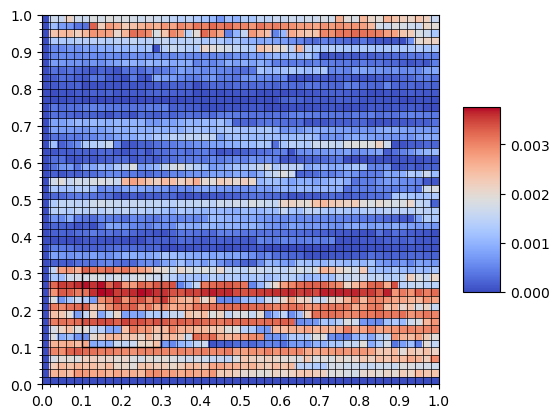

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()
hx = 0.1
# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad2.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.5)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx)

plt.xticks(major_ticks)
plt.yticks(major_ticks)

plt.show()

(d) My PCG

In [28]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import norm

def myPCG( A, b, L, U, tol, maxit ):
    #A is the matrix produced by diffusionMatrix
    #b is the RHS calculated by the source function
    #L and U are the factors of the preconditioner from spilu
    #tol is the tolerance for the residual
    # maxit is the maximum number of iterations
    N = len(b)

    r = b - A@x0 #residual
    M = L@U
    z0 = ...
    z = z0
    r = M@z #preconditioned residual
    r = r0
    d0 = z0 #preconditioned search direction
    d = d0
    

    while i < maxit and norm(r) > tol:
        alpha = (r0.T@z0)/(d.T@A@d)
        x = x + alpha*d
        r = r0 - alpha*A@d0
        beta = (r1.T@M@r1)/(r0.T@M@r0)
        d1 = r1 + beta*d0
        r0 = r1
        d0 = d1
        i += 1

    iterate_counts = 0
    def iterate_count(x):
        iterate_count.iterate_counts += 1

    iterate_count.iterate_counts = 0

    M = L@U

    f = sp.sparse.csc_array((N, 1), dtype=np.float64)
    f, info = sp.sparse.linalg.cg(A, b, x0=None, tol=tol, maxiter=maxit, M=M, callback=iterate_count, atol=None)
    return f, info

In [30]:
#Using the myPCG function
mux = 1
muy = 1
h = 0.02
n = int(1./h + 1)  # dimension of spatial mesh in each dimension
N = n**2
droptol = 0.1
tol = 0.1
maxit = 10000

A = diffusionMatrix(mux, muy, h)
intNodes, extNodes = boundaryConditions(n)
b = np.zeros((N, 1), dtype=np.float64)

# Evaluate the source function
for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    b[k] = source_function( i*h, j*h )

A_int = A[intNodes][:, intNodes]
b_int = b[intNodes]

M = sp.sparse.linalg.spilu(A_int, drop_tol=droptol)

#sol = myPCG(A_int,b_int,M.L,M.U,tol,maxit)



In [ ]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

h = 0.1
n = int(1./h + 1)
N = n**2
mux = 1
muy = 1
droptol = 0.1
intNodes, extNodes = boundaryConditions(int(1./h+1))

#A matrix
A = diffusionMatrix(mux, muy, h)
A = A.todense()

A_intNodes = A[intNodes][:, intNodes]

solgrad3 = np.zeros_like(A)
#Preconditioner matrix
M = sp.sparse.linalg.spilu(A_intNodes, drop_tol=droptol)

#Seperate L and U matrices
L = M.L
U = M.U

#b matrix
F = np.zeros((N, 1), dtype=np.float64)

# Evaluate the source function
for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )

F_int = F[intNodes]

solgrad3[intNodes] = myPCG(A_intNodes, F_int, L, U, 1e-6, 1000)
solgrad3[extNodes] = 0



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()
h = 0.1
hx = 0.1
# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad3

# Plot the surface.
surf = ax.pcolor(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.5)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx)

plt.xticks(major_ticks)
plt.yticks(major_ticks)

plt.show()